In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

In [2]:
%store -r lst
listings = lst.copy()

In [3]:
listings.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,3176,https://www.airbnb.com/rooms/3176,20250315152850,2025-03-16,city scrape,Fabulous Flat in great Location,This beautiful first floor apartment is situa...,The neighbourhood is famous for its variety of...,https://a0.muscache.com/pictures/airflow/Hosti...,3718.0,...,4.70,4.92,4.61,First name and Last name: Nicolas Krotz <br/> ...,False,1,1,0,0,0.78
1,9991,https://www.airbnb.com/rooms/9991,20250315152850,2025-03-16,city scrape,Geourgeous flat - outstanding views,4 bedroom with very large windows and outstand...,Prenzlauer Berg is an amazing neighbourhood wh...,https://a0.muscache.com/pictures/42799131/59c8...,33852.0,...,5.00,4.86,4.86,03/Z/RA/003410-18,False,1,1,0,0,0.06
2,14325,https://www.airbnb.com/rooms/14325,20250315152850,2025-03-16,city scrape,Studio Apartment in Prenzlauer Berg,The apartment is located on the upper second f...,Unknown,https://a0.muscache.com/pictures/508703/24988a...,55531.0,...,4.85,4.60,4.45,Unknown,False,4,4,0,0,0.15
3,16644,https://www.airbnb.com/rooms/16644,20250315152850,2025-03-16,city scrape,In the Heart of Berlin - Kreuzberg,Light and sunny 2-Room-turn of the century-fla...,Our Part of Kreuzberg is just the best. Good v...,https://a0.muscache.com/pictures/73759174/e2ef...,64696.0,...,4.86,4.67,4.71,Unknown,False,2,2,0,0,0.27
4,17904,https://www.airbnb.com/rooms/17904,20250315152850,2025-03-16,city scrape,Beautiful Kreuzberg studio - 3 months minimum,"- apt is available starting September 1, 2024<...","The apartment is located in Kreuzberg, which i...",https://a0.muscache.com/pictures/d9a6f8be-54b9...,68997.0,...,4.92,4.87,4.65,Unknown,False,1,1,0,0,1.63


Remove extra columns

In [4]:
listings.drop(
    [
        "neighbourhood",
        "neighborhood_overview",
        "host_name",
        "host_url",
        "host_thumbnail_url",
        "host_picture_url",
        "host_verifications",
        "host_about",
        "host_location",
        "host_neighbourhood",
        "bathrooms_text",
        "minimum_minimum_nights",
        "maximum_minimum_nights",
        "minimum_maximum_nights",
        "maximum_maximum_nights",
        "listing_url",
        "scrape_id",
        "last_scraped",
        "source",
        "description",
        "picture_url",
        "host_id",
        "name",
        "host_has_profile_pic",
        "host_identity_verified",
        "latitude",
        "longitude",
        "has_availability",
        "calendar_updated",
        "calendar_last_scraped",
        "estimated_revenue_l365d",
        "first_review",
        "last_review",
        "review_scores_accuracy",
        "license",
        "id",
        "instant_bookable",
        "calculated_host_listings_count",
        "calculated_host_listings_count_private_rooms",
        "host_response_time",
        "calculated_host_listings_count_shared_rooms",
        "neighbourhood_cleansed",
    ],
    axis=1,
    inplace=True,
)

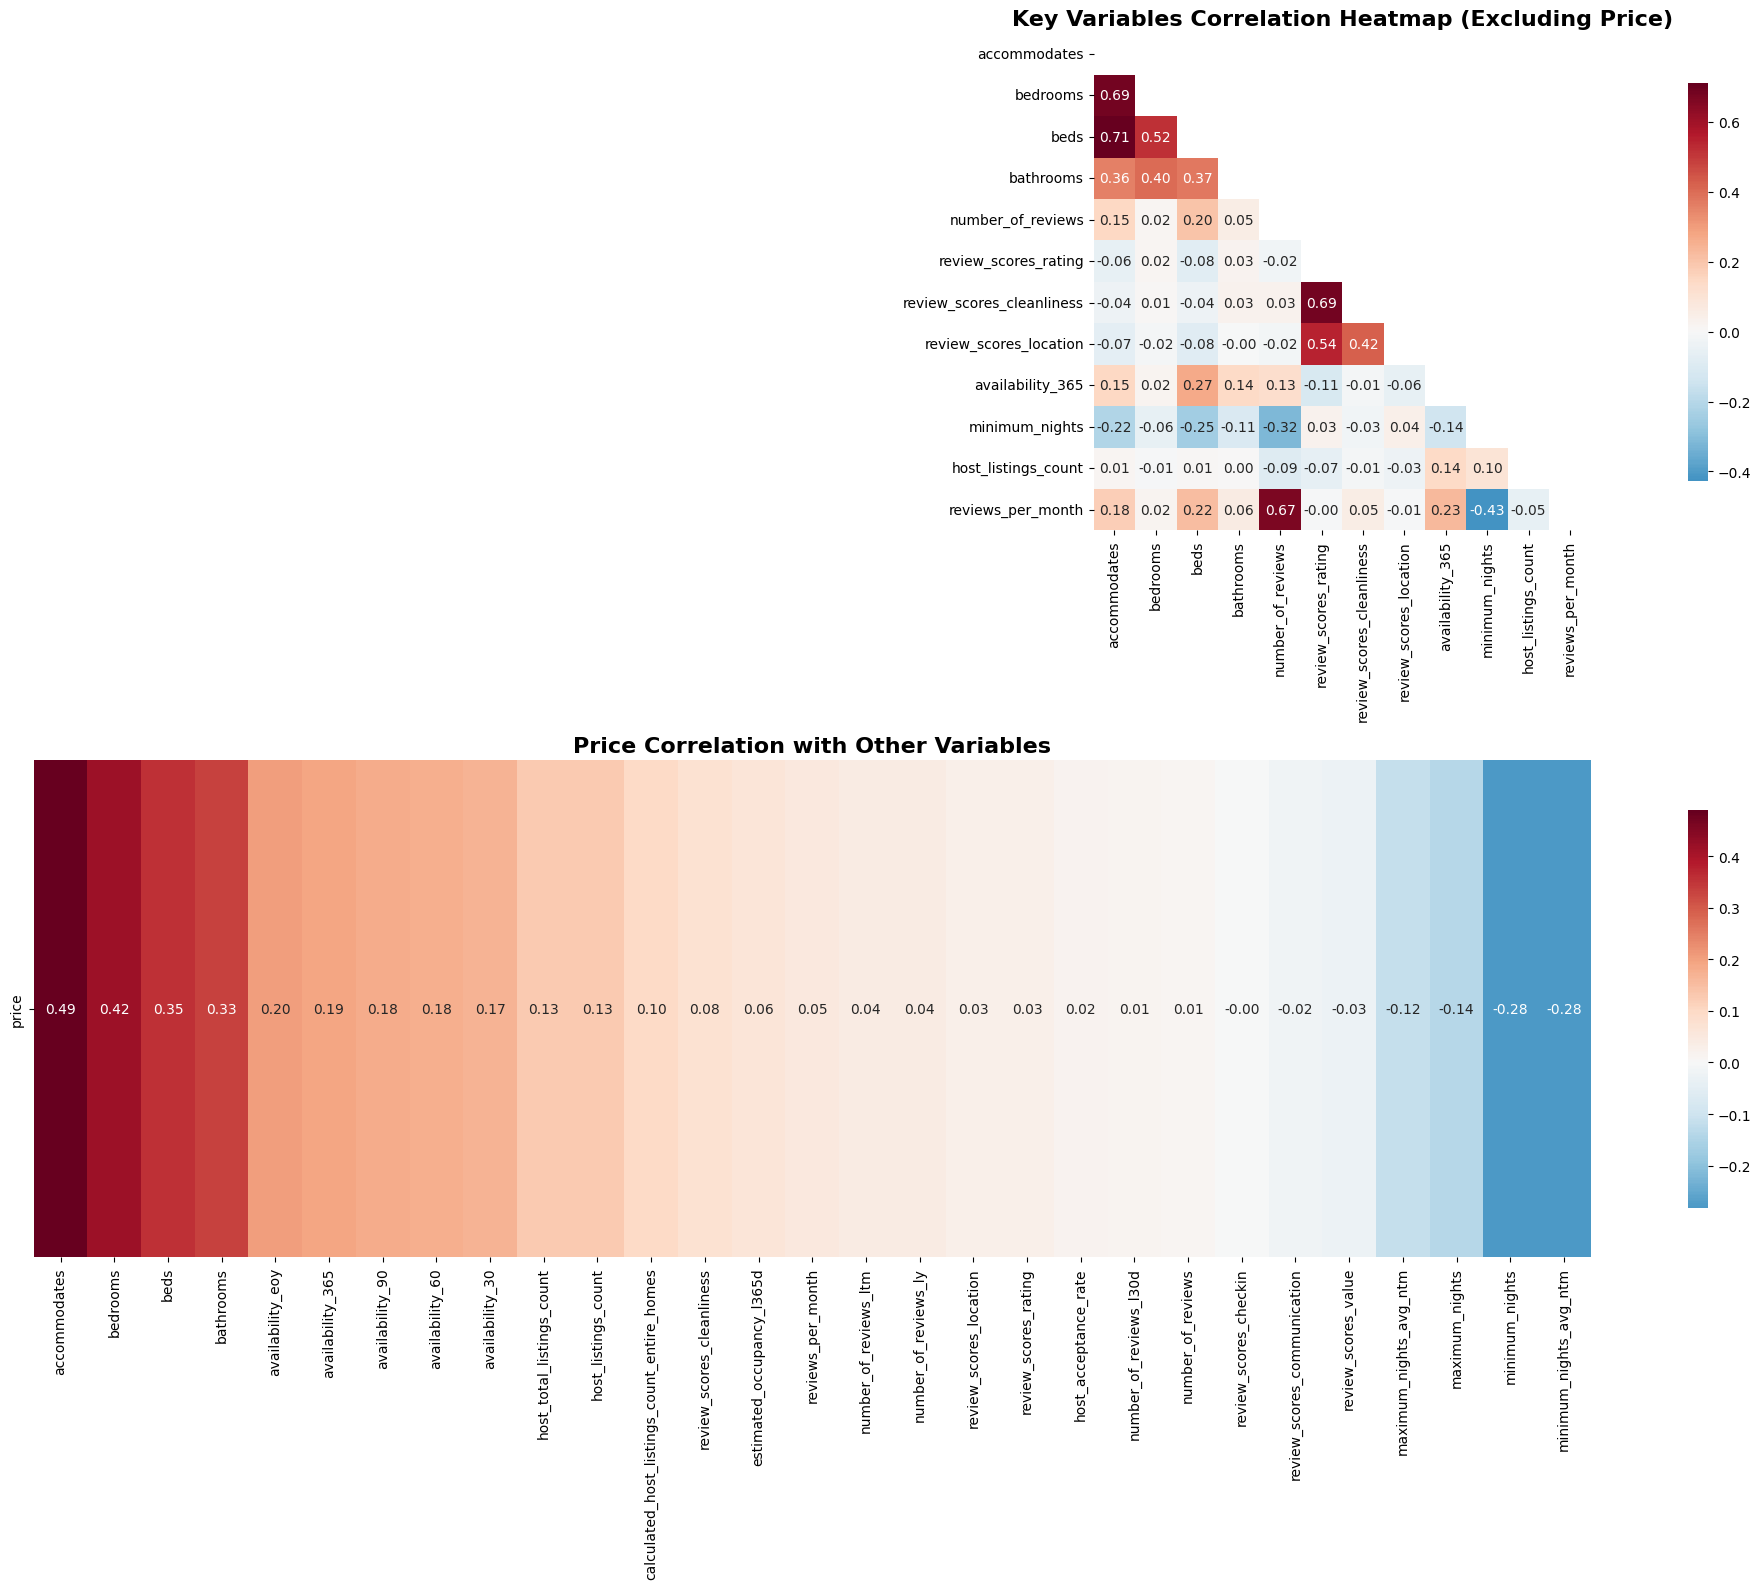

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

numeric_cols = listings.select_dtypes(include=[np.number]).columns.tolist()
df_numeric = listings[numeric_cols]

# 1. CORRELATION HEATMAP (excluding price) - Select key variables only
plt.figure(figsize=(20, 16))

plt.subplot(2, 1, 1)

key_vars = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews', 
            'review_scores_rating', 'review_scores_cleanliness', 'review_scores_location',
            'availability_365', 'minimum_nights', 'host_listings_count', 
            'calculated_host_listings_count', 'reviews_per_month']


key_vars_available = [var for var in key_vars if var in df_numeric.columns]
df_key = df_numeric[key_vars_available]
corr_key = df_key.corr()


mask = np.triu(np.ones_like(corr_key, dtype=bool))

sns.heatmap(corr_key, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})
plt.title('Key Variables Correlation Heatmap (Excluding Price)', fontsize=16, fontweight='bold')


plt.subplot(2, 1, 2)
price_corr = df_numeric.corr()[['price']].drop('price')
price_corr_sorted = price_corr.sort_values('price', ascending=False)

sns.heatmap(price_corr_sorted.T, 
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            fmt='.2f',
            cbar_kws={"shrink": .8})
plt.title('Price Correlation with Other Variables', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

Amenity engineering

In [6]:
import ast
from collections import Counter


def parse_amenities(amenities_str):
    """
    Parse the amenities string into a list of individual amenities
    """
    try:
        # Handle string representation of list
        if isinstance(amenities_str, str):
            return ast.literal_eval(amenities_str)
        return amenities_str if amenities_str else []
    except:
        return []


def create_amenity_features(df):
    """
    Create comprehensive amenity-based features
    """
    # Parse all amenities
    df["amenities_list"] = df["amenities"].apply(parse_amenities)

    # Basic amenity count
    df["amenity_count"] = df["amenities_list"].apply(len)

    # Get all unique amenities across dataset
    all_amenities = []
    for amenities in df["amenities_list"]:
        all_amenities.extend(amenities)

    amenity_counter = Counter(all_amenities)
    print(f"Total unique amenities found: {len(amenity_counter)}")
    print("Top 20 most common amenities:")
    for amenity, count in amenity_counter.most_common(20):
        print(f"  {amenity}: {count} listings ({count/len(df)*100:.1f}%)")

    return df, amenity_counter


def create_amenity_categories(amenity_counter, min_frequency=50):
    """
    Group amenities into logical categories for feature engineering
    """
    # Define amenity categories (you can expand these based on your data)
    categories = {
        "luxury": [
            "Private hot tub",
            "Wine glasses",
            "Bathtub",
            "Patio or balcony",
            "Outdoor dining area",
            "Outdoor furniture",
            "Hot tub",
        ],
        "kitchen_full": [
            "Kitchen",
            "Refrigerator",
            "Stove",
            "Oven",
            "Freezer",
            "Cooking basics",
            "Dishes and silverware",
        ],
        "kitchen_basic": [
            "Coffee maker",
            "Coffee",
            "Toaster",
            "Hot water kettle",
            "Baking sheet",
        ],
        "safety": [
            "Smoke alarm",
            "Carbon monoxide alarm",
            "Fire extinguisher",
            "First aid kit",
        ],
        "tech": ["Wifi", "TV", "Ethernet connection"],
        "comfort": [
            "Heating",
            "Hot water",
            "Bed linens",
            "Extra pillows and blankets",
            "Hair dryer",
            "Iron",
        ],
        "storage": ["Clothing storage", "Hangers"],
        "cleaning": ["Washer", "Cleaning products", "Essentials"],
        "family": ["High chair", "Crib", "Children's dinnerware"],
        "entertainment": ["Books and reading material", "Board games"],
        "hosting": ["Host greets you", "Long term stays allowed"],
    }

    # Filter categories to only include amenities that exist in our data
    filtered_categories = {}
    for category, amenities in categories.items():
        existing_amenities = [a for a in amenities if a in amenity_counter]
        if existing_amenities:
            filtered_categories[category] = existing_amenities

    return filtered_categories


def engineer_amenity_features(df, categories):
    """
    Create category-based amenity features
    """
    # Category presence flags
    for category, amenities in categories.items():
        df[f"has_{category}"] = (
            df["amenities_list"]
            .apply(lambda x: any(amenity in x for amenity in amenities))
            .astype(int)
        )

    # Category counts (how many amenities from each category)
    for category, amenities in categories.items():
        df[f"{category}_count"] = df["amenities_list"].apply(
            lambda x: sum(1 for amenity in amenities if amenity in x)
        )

    # Premium amenity score (based on less common, high-value amenities)
    premium_amenities = [
        "Private hot tub",
        "Wine glasses",
        "Outdoor dining area",
        "Ethernet connection",
        "Patio or balcony",
    ]
    df["premium_amenity_score"] = df["amenities_list"].apply(
        lambda x: sum(1 for amenity in premium_amenities if amenity in x)
    )

    # Essential amenity score (basic necessities)
    essential_amenities = ["Wifi", "Kitchen", "Hot water", "Bed linens", "Heating"]
    df["essential_amenity_score"] = df["amenities_list"].apply(
        lambda x: sum(1 for amenity in essential_amenities if amenity in x)
    )

    return df


# Execute the pipeline
print("🔧 STARTING AMENITY FEATURE ENGINEERING...")

# Step 1: Parse and analyze amenities
listings_enhanced, amenity_counter = create_amenity_features(listings)

# Step 2: Create amenity categories
categories = create_amenity_categories(amenity_counter)
print(f"\n📊 Created {len(categories)} amenity categories:")
for cat, amenities in categories.items():
    print(f"  {cat}: {len(amenities)} amenities")

# Step 3: Engineer features
listings_enhanced = engineer_amenity_features(listings_enhanced, categories)

print(
    f"\n COMPLETED! Added {len([col for col in listings_enhanced.columns if 'amenity' in col or any(cat in col for cat in categories.keys())])} new amenity features"
)

🔧 STARTING AMENITY FEATURE ENGINEERING...
Total unique amenities found: 2766
Top 20 most common amenities:
  Kitchen: 12720 listings (91.3%)
  Wifi: 12637 listings (90.7%)
  Essentials: 10768 listings (77.3%)
  Smoke alarm: 10387 listings (74.5%)
  Hair dryer: 10090 listings (72.4%)
  Hot water: 9756 listings (70.0%)
  Hangers: 9520 listings (68.3%)
  Heating: 9033 listings (64.8%)
  Dishes and silverware: 8790 listings (63.1%)
  Cooking basics: 8414 listings (60.4%)
  Bed linens: 8372 listings (60.1%)
  Refrigerator: 8219 listings (59.0%)
  Washer: 8134 listings (58.4%)
  Iron: 8082 listings (58.0%)
  Dedicated workspace: 6828 listings (49.0%)
  Shampoo: 6198 listings (44.5%)
  Hot water kettle: 5922 listings (42.5%)
  TV: 5783 listings (41.5%)
  Dishwasher: 5733 listings (41.1%)
  Oven: 5511 listings (39.6%)

📊 Created 11 amenity categories:
  luxury: 7 amenities
  kitchen_full: 7 amenities
  kitchen_basic: 5 amenities
  safety: 4 amenities
  tech: 3 amenities
  comfort: 6 amenities


In [7]:
def convert_float(val):
    if isinstance(val, str) and val.endswith('%'):
        return float(val.strip('%'))
    else:
        return 0.0

def convert_date(val):
    if isinstance(val, str):
        return 2025 - int(val.split('-')[0])

listings['host_response_rate'] = listings['host_response_rate'].apply(convert_float)
listings['host_since'] = listings['host_since'].apply(convert_date)

listings['neighbourhood_group_cleansed'] = listings['neighbourhood_group_cleansed'].astype('category')
listings['room_type'] = listings['room_type'].astype('category')

In [8]:
#listings.to_csv("../data/processed/listings_cleaned.csv", index=False)

In [9]:
listings_encoded = pd.read_csv("../data/processed/listings_cleaned.csv", index_col=0)
listings_encoded.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,...,safety_count,tech_count,comfort_count,storage_count,cleaning_count,family_count,entertainment_count,hosting_count,premium_amenity_score,essential_amenity_score
host_since,,,,,,,,,,,,,,,,,,,,,
NaN,67.0,0.40,False,1.0,1.0,Pankow,Entire rental unit,Entire home/apt,2,1.0,...,4,3,6,2,3,2,2,2,5,5
NaN,0.0,0.00,False,1.0,1.0,Pankow,Entire rental unit,Entire home/apt,7,2.5,...,1,1,5,1,2,2,0,0,0,5
NaN,100.0,0.38,True,4.0,5.0,Pankow,Entire rental unit,Entire home/apt,1,1.0,...,1,3,2,1,1,0,0,1,1,4
NaN,0.0,0.00,False,4.0,4.0,Friedrichshain-Kreuzberg,Entire condo,Entire home/apt,4,1.0,...,3,2,3,1,2,1,0,0,0,3
NaN,100.0,0.95,False,2.0,5.0,Neukölln,Entire rental unit,Entire home/apt,2,1.0,...,0,2,4,1,1,0,0,1,0,4


One hot encoding categorical features


In [10]:
listings_encoded = pd.get_dummies(
    listings, columns=["neighbourhood_group_cleansed", "room_type"]
)
listings_encoded.head()

,host_since,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,property_type,accommodates,bathrooms,bedrooms,...,neighbourhood_group_cleansed_Pankow,neighbourhood_group_cleansed_Reinickendorf,neighbourhood_group_cleansed_Spandau,neighbourhood_group_cleansed_Steglitz - Zehlendorf,neighbourhood_group_cleansed_Tempelhof - Schöneberg,neighbourhood_group_cleansed_Treptow - Köpenick,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,None,67.0,0.40,False,1.0,1.0,Entire rental unit,2,1.0,1.0,...,True,False,False,False,False,False,True,False,False,False
1,None,0.0,0.00,False,1.0,1.0,Entire rental unit,7,2.5,4.0,...,True,False,False,False,False,False,True,False,False,False
2,None,100.0,0.38,True,4.0,5.0,Entire rental unit,1,1.0,0.0,...,True,False,False,False,False,False,True,False,False,False
3,None,0.0,0.00,False,4.0,4.0,Entire condo,4,1.0,1.0,...,False,False,False,False,False,False,True,False,False,False
4,None,100.0,0.95,False,2.0,5.0,Entire rental unit,2,1.0,0.0,...,False,False,False,False,False,False,True,False,False,False


In [11]:
def train_and_eval(model, X_train, y_train, X_test, y_test, depth, estim=None):
    """
    Runs training and evaluation of given decision tree or random forest
    regressor and prints resulting metrics.
    """

    model.fit(X_train, y_train)
    extra_str = "" if estim is None else f"{estim} estimators and "
    print(f"\nTraining {model.__class__.__name__} with {extra_str} max_depth={depth}\n")

    # results on training set
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    # results on test set
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error - train: {train_mae}, test: {mae}")
    print(f"Root Mean Squared Error - train: {train_rmse}, test: {rmse}")
    print(f"R^2 Score - train: {train_r2}, test: {r2}")

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    listings_encoded.drop("price", axis=1),
    listings_encoded["price"],
    test_size=0.2,
)

In [ ]:
# ----------------------------------
# Random Forest Hyperparameter Search
# ----------------------------------
for estim in [100, 200]:
    for depth in [10, 15, 20]:

        model = RandomForestRegressor(
            n_estimators=estim, random_state=42, max_depth=depth
        )

        train_and_eval(
            model, X_train, y_train, X_test, y_test, estim=estim, depth=depth
        )

# ----------------------------------
# Decision Tree Hyperparameter Search
# ----------------------------------

for depth in [5, 8, 10, 12]:
    model = DecisionTreeRegressor(max_depth=depth)
    train_and_eval(model, X_train, y_train, X_test, y_test, depth=depth)

ValueError: could not convert string to float: 'Entire rental unit'